# \begin{align}
    \color{yellow}{\textbf{Proyecto Telecom X Latam: Predicción de Cancelación}}
\end{align}

$\color{yellow}{\textbf{Sobre el proyecto:}}$

<p>El desafío <strong>Telecom X Latam-parte 2</strong> forma parte de la formación de Data Science del programa ONE, especificamente de la ruta Machine Learning.</p>

<p>La empresa Telecom X está enfrentando una alta tasa de cancelaciones y en una primera instancia, como parte del equipo de análisis de datos, se realizó el análisis exploratorio para detectar los factores que están llevando a los usuarios a dejar la empresa.<br>

Una vez indentificados patrones o tendencias que llevan a las personas a cancelar los servicios de la empresa, como parte del equipo de Machine Learning, desarrollamos modelos de clasificación:<strong> Árbol de Decisión y Regresión logística</strong>, capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación, y le corresponde al equipo construir un pipeline robusto para esta etapa inicial de modelado.</p>



$\color{yellow}{\textbf{Objetivos del desafío:}}$

<ul>
<li>Preparar los datos para el modelado (tratamiento, codificación, normalización).</li>

<li>Realizar análisis de correlación y selección de variables.
Entrenar dos o más modelos de clasificación.</li>

<li>Evaluar el rendimiento de los modelos con métricas.</li>

<li>Interpretar los resultados, incluyendo la importancia de las variables.</li>

<li>Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.</li>
</ul>

$\color{yellow}{\textbf{Prácticas del desafío:}}$

<ul>
<li> Preprocesamiento de datos para Machine Learning.</li>
<li> Construcción y evaluación de modelos predictivos.</li>
<li> Interpretación de resultados y entrega de insights.</li>
<li> Comunicación técnica con enfoque estratégico.</li>
</u>

## $\color{yellow}{\textbf{Preprocesamiento de los datos:}}$

In [288]:
#Importamos bibliotecas para manipular y visualizar los datos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [289]:
#Lectura del df limpio obtenido en el desafío anterior
ruta = '/content/drive/MyDrive/Colab Notebooks/datos_limpios.csv'
clientes = pd.read_csv(ruta)

In [290]:
clientes.head()

,customerID,Churn,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesMonthly,ChargesTotal,CuentasDiarias
0,0002-orfbo,no,female,0,yes,yes,9,yes,no,dsl,...,no,yes,yes,no,one-year,yes,mailed check,65.6,593.30,2.186667
1,0003-mknfe,no,male,0,no,no,9,yes,yes,dsl,...,no,no,no,yes,month-to-month,no,mailed check,59.9,542.40,1.996667
2,0004-tlhlj,yes,male,0,no,no,4,yes,no,fiber optic,...,yes,no,no,no,month-to-month,yes,electronic check,73.9,280.85,2.463333
3,0011-igkff,yes,male,1,yes,no,13,yes,no,fiber optic,...,yes,no,yes,yes,month-to-month,yes,electronic check,98.0,1237.85,3.266667
4,0013-exchz,yes,female,1,yes,no,3,yes,no,fiber optic,...,no,yes,yes,no,month-to-month,yes,mailed check,83.9,267.40,2.796667


In [291]:
#Eliminamos las columnas que no tienen relevancia para el modelo
clientes.drop(columns=['customerID','Gender','CuentasDiarias'],
              inplace=True)

In [292]:
#Eliminamos los valores NaN de la columna ChargesTotal
clientes.dropna(inplace=True)
clientes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Churn             7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   Tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

In [293]:
#Identificamos las columnas categóricas
columnas_categoricas = clientes.select_dtypes(include='object').columns
columnas_categoricas

Index(['Churn', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [294]:
#Función para obtener los valores únicos de cada columna categórica
def valores_unicos(df):
  columnas_categoricas = df.select_dtypes(include='object').columns
  for columna in columnas_categoricas:
    print(f'{columna}: {df[columna].unique()}')

In [295]:
valores_unicos(clientes)

Churn: ['no' 'yes']
Partner: ['yes' 'no']
Dependents: ['yes' 'no']
PhoneService: ['yes' 'no']
MultipleLines: ['no' 'yes' 'no phone service']
InternetService: ['dsl' 'fiber optic' 'no internet service']
OnlineSecurity: ['no' 'yes' 'no internet service']
OnlineBackup: ['yes' 'no' 'no internet service']
DeviceProtection: ['no' 'yes' 'no internet service']
TechSupport: ['yes' 'no' 'no internet service']
StreamingTV: ['yes' 'no' 'no internet service']
StreamingMovies: ['no' 'yes' 'no internet service']
Contract: ['one-year' 'month-to-month' 'two-year']
PaperlessBilling: ['yes' 'no']
PaymentMethod: ['mailed check' 'electronic check' 'credit card' 'bank transfer']


In [296]:
#Llamamos la función valores_unicos para ver los valores únicos del df clientes
clientes[['MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies']] = clientes[['MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies']].replace({'no internet service':'no', 'no phone service':'no'})

valores_unicos(clientes)

Churn: ['no' 'yes']
Partner: ['yes' 'no']
Dependents: ['yes' 'no']
PhoneService: ['yes' 'no']
MultipleLines: ['no' 'yes']
InternetService: ['dsl' 'fiber optic' 'no']
OnlineSecurity: ['no' 'yes']
OnlineBackup: ['yes' 'no']
DeviceProtection: ['no' 'yes']
TechSupport: ['yes' 'no']
StreamingTV: ['yes' 'no']
StreamingMovies: ['no' 'yes']
Contract: ['one-year' 'month-to-month' 'two-year']
PaperlessBilling: ['yes' 'no']
PaymentMethod: ['mailed check' 'electronic check' 'credit card' 'bank transfer']


### $\color{yellow}{\textbf{Analizando la relación entre variables categóricas}}$

In [297]:
from scipy.stats import chi2_contingency

In [298]:
"""
Función que calcula el coeficiente de Cramer
Utilizamos el coeficiente corregido de V-Cramer, ya que el no corregido puede
introducir sesgos
"""
def v_cramer_corregido(col1, col2):
  tabla_cont = pd.crosstab(col1, col2)
  estadistico_chi2 = chi2_contingency(tabla_cont)[0]
  n = tabla_cont.sum().sum()
  estadistico_phi2 = estadistico_chi2 / n
  renglon, columnas = tabla_cont.shape
  phi2corr = max(0, estadistico_phi2 - ((columnas-1)*(renglon-1))/(n-1))
  renglon_corr = renglon - ((renglon-1)**2)/(n-1)
  columnas_corr = columnas - ((columnas-1)**2)/(n-1)
  return np.sqrt(phi2corr / min((columnas_corr-1), (renglon_corr-1)))

In [299]:
#Creamos una variable con los nombres de las columnas categóricas
variables_cat = ['Churn', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod']
variables_cat

['Churn',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [300]:
#Creamos la matriz que guardará los coeficientes de V de Cramer
v_cramer_matrix = pd.DataFrame(index=variables_cat, columns=variables_cat)
v_cramer_matrix

,Churn,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
Churn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Partner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PhoneService,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineBackup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DeviceProtection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TechSupport,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [301]:
#Guardamos en la matriz anterior el coeficiente para cada par de variables categóricas
for col1 in variables_cat:
    for col2 in variables_cat:
      v_cramer_matrix.loc[col1, col2] = v_cramer_corregido(clientes[col1], clientes[col2])
v_cramer_matrix

,Churn,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
Churn,0.999636,0.149194,0.162351,0.0,0.037876,0.32149,0.170509,0.081102,0.064769,0.16394,0.061787,0.059347,0.409242,0.190768,0.302276
Partner,0.149194,0.999715,0.451833,0.013371,0.141783,0.0,0.142543,0.141057,0.152803,0.119306,0.123625,0.117219,0.294869,0.006676,0.162568
Dependents,0.162351,0.451833,0.99966,0.0,0.02082,0.177625,0.079559,0.020032,0.00648,0.061571,0.010934,0.036142,0.241117,0.109173,0.147969
PhoneService,0.0,0.013371,0.0,0.999186,0.278807,0.451973,0.090366,0.050235,0.068544,0.09386,0.01715,0.030755,0.0,0.010974,0.0
MultipleLines,0.037876,0.141783,0.02082,0.278807,0.999708,0.368858,0.097554,0.201587,0.201091,0.099398,0.25725,0.258642,0.10905,0.163029,0.226983
InternetService,0.32149,0.0,0.177625,0.451973,0.368858,1.0,0.392984,0.380866,0.379805,0.390224,0.442398,0.442296,0.205381,0.377616,0.311601
OnlineSecurity,0.170509,0.142543,0.079559,0.090366,0.097554,0.392984,0.999652,0.282722,0.274304,0.353936,0.174797,0.186736,0.251065,0.0,0.174008
OnlineBackup,0.081102,0.141057,0.020032,0.050235,0.201587,0.380866,0.282722,0.999685,0.302529,0.293153,0.281061,0.273976,0.163954,0.126198,0.187836
DeviceProtection,0.064769,0.152803,0.00648,0.068544,0.201091,0.379805,0.274304,0.302529,0.999685,0.33233,0.389461,0.401853,0.22757,0.103094,0.204346
TechSupport,0.16394,0.119306,0.061571,0.09386,0.099398,0.390224,0.353936,0.293153,0.33233,0.999655,0.27699,0.279599,0.296279,0.035257,0.180188


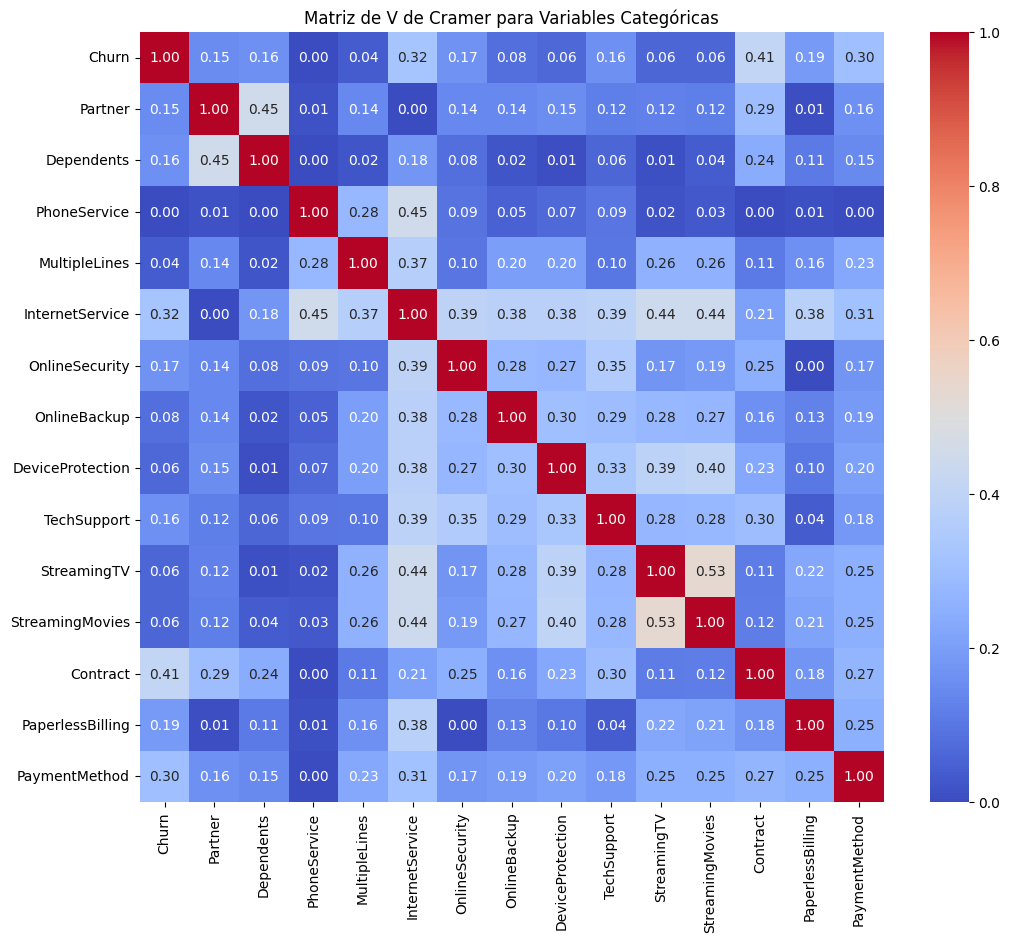

In [302]:
#Gráfico de la matriz de Cramer
plt.figure(figsize=(12, 10))
sns.heatmap(v_cramer_matrix.astype(float), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de V de Cramer para Variables Categóricas")
plt.show()

In [303]:
#Filtro para elegir las variables categóricas que tienen una relación más fuerte con Churn
target_var = 'Churn'
v_relevantes = v_cramer_matrix.index[abs(v_cramer_matrix[target_var]) >= 0.20].tolist()
v_relevantes

['Churn', 'InternetService', 'Contract', 'PaymentMethod']

In [304]:
"""
Creamos otra matriz con solo los coeficientes de las variables
más fuertemente relacionadas con Churn
"""
v_filtrada = v_cramer_matrix.loc[v_relevantes, v_relevantes]
v_filtrada

,Churn,InternetService,Contract,PaymentMethod
Churn,0.999636,0.32149,0.409242,0.302276
InternetService,0.32149,1.0,0.205381,0.311601
Contract,0.409242,0.205381,1.0,0.265958
PaymentMethod,0.302276,0.311601,0.265958,1.0


In [305]:
"""
Creamos una máscara booleana para ocultar el triángulo superior
de la matriz anterior
"""
mascara = np.triu(np.ones_like(v_filtrada, dtype=bool))

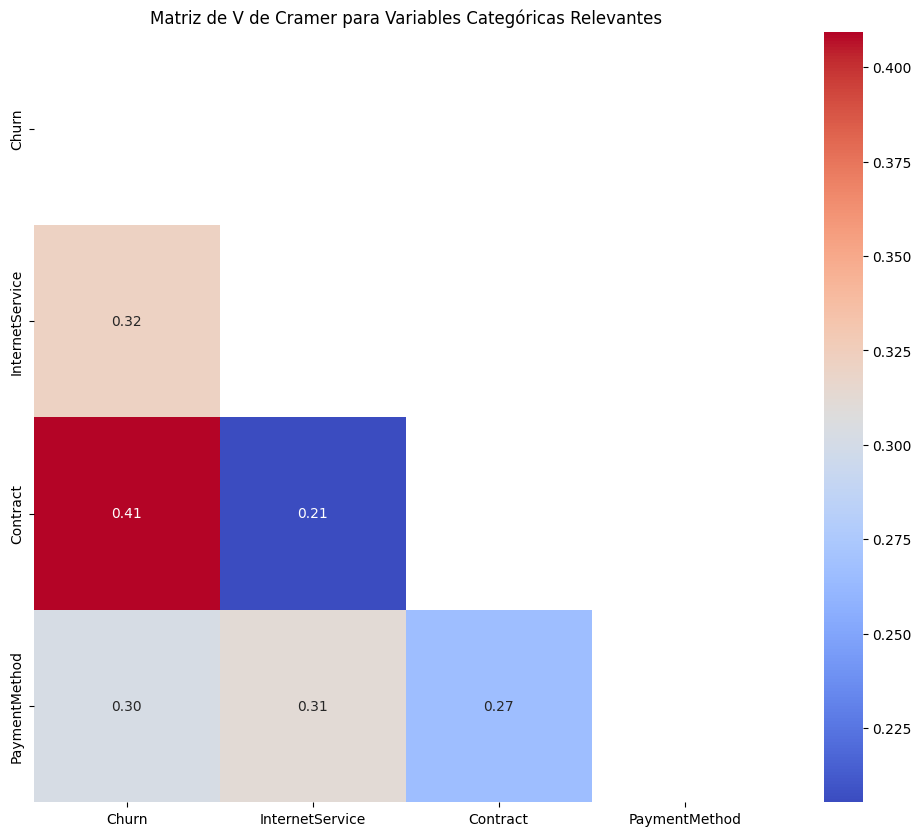

In [306]:
#Gráfico de la matriz filtrada
plt.figure(figsize=(12, 10))
sns.heatmap(v_filtrada.astype(float), annot=True, cmap='coolwarm', fmt=".2f", mask=mascara)
plt.title("Matriz de V de Cramer para Variables Categóricas Relevantes")
plt.show()

### $\color{yellow}{\textbf{Correlación entre variables numéricas y con churn}}$


In [307]:
"""
Seleccionamos las variables numéricas y luego calculamos la correlación entre
las variables númericas más la variable objetivo churn
"""
variables_numericas = clientes.select_dtypes(include=['number'])
variables_numericas['Churn'] = clientes['Churn'].replace({'no': 0, 'yes': 1})
print('\t\tMatriz de Correlación entre variables numéricas independientes y churn\t\t')
print(variables_numericas.drop(columns='SeniorCitizen', axis=1).corr())

		Matriz de Correlación entre variables numéricas independientes y churn		
                  Tenure  ChargesMonthly  ChargesTotal     Churn
Tenure          1.000000        0.246862      0.825880 -0.354049
ChargesMonthly  0.246862        1.000000      0.651065  0.192858
ChargesTotal    0.825880        0.651065      1.000000 -0.199484
Churn          -0.354049        0.192858     -0.199484  1.000000


/tmp/ipython-input-2221883665.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  variables_numericas['Churn'] = clientes['Churn'].replace({'no': 0, 'yes': 1})


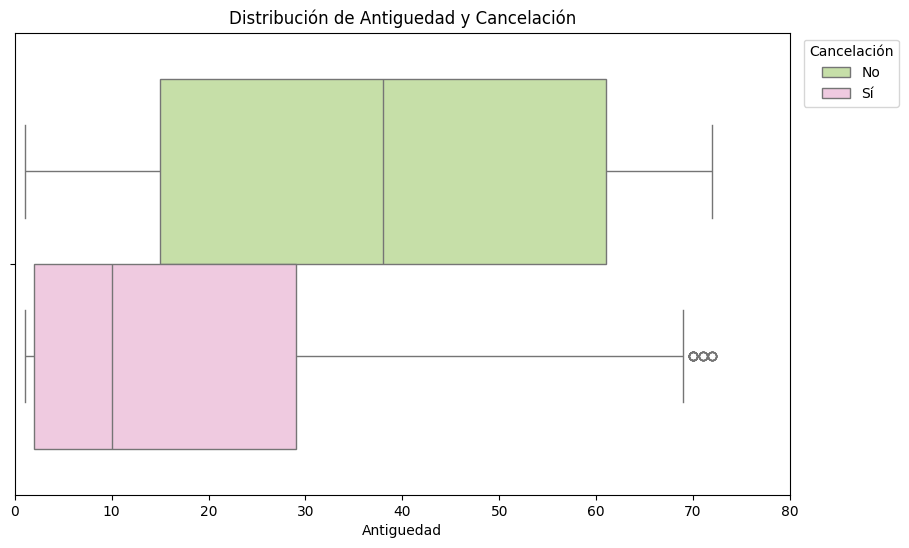

In [308]:
#Distribución de Tenure según si los clientes hiceron o no churn
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(data=variables_numericas, x='Tenure', hue='Churn', palette='PiYG_r')
ax.set_title('Distribución de Antiguedad y Cancelación')
ax.set_xlabel('Antiguedad')
ax.set_xlim(0,80)
ax.legend(title="Cancelación",labels=['No', 'Sí'], loc='best',  bbox_to_anchor=(1,0.70,0.15,0.3))

plt.show()

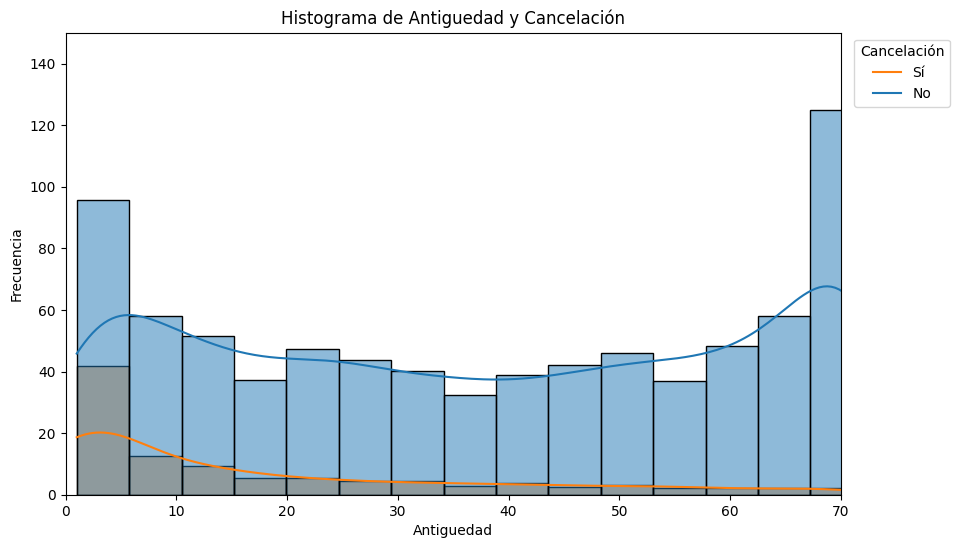

In [309]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.histplot(variables_numericas,x='Tenure', hue='Churn', kde=True, stat='frequency')
ax.set_title('Histograma de Antiguedad y Cancelación')
ax.set_xlabel('Antiguedad')
ax.set_ylabel('Frecuencia')
ax.set_xlim(0,70)
ax.set_ylim(0,150)
ax.legend(title="Cancelación",labels=['Sí', 'No'], loc='upper right', bbox_to_anchor=(1,0.70,0.15,0.3))

plt.show()


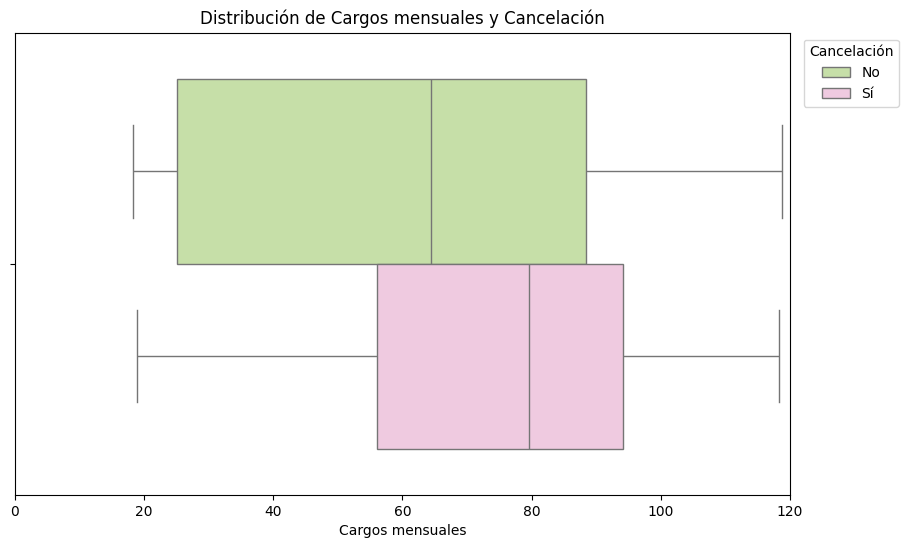

In [310]:
#Distribución de cargos mensuales según si los clientes hiceron o no churn
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(data=variables_numericas, x='ChargesMonthly', hue='Churn', palette='PiYG_r')
ax.set_title('Distribución de Cargos mensuales y Cancelación')
ax.set_xlabel('Cargos mensuales')
ax.set_xlim(0,120)
ax.legend(title="Cancelación",labels=['No', 'Sí'], loc='upper right', bbox_to_anchor=(1,0.70,0.15,0.3))

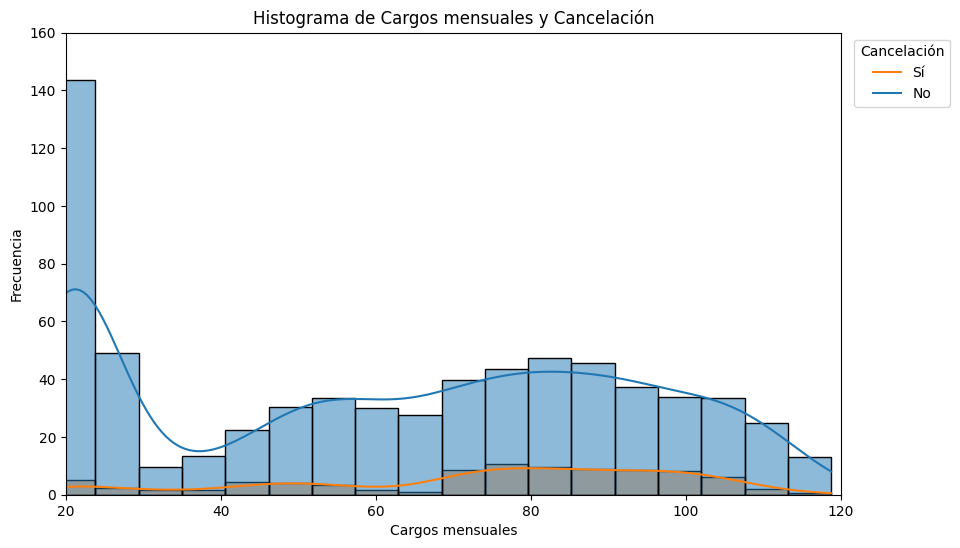

In [311]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(variables_numericas,x='ChargesMonthly', hue='Churn',kde=True, stat='frequency')
ax.set_title('Histograma de Cargos mensuales y Cancelación')
ax.set_xlabel('Cargos mensuales')
ax.set_ylabel('Frecuencia')
ax.set_xlim(20,120)
ax.set_ylim(0,160)
ax.legend(title="Cancelación",labels=['Sí', 'No'], loc='upper right', bbox_to_anchor=(1,0.70,0.15,0.3))

plt.show()

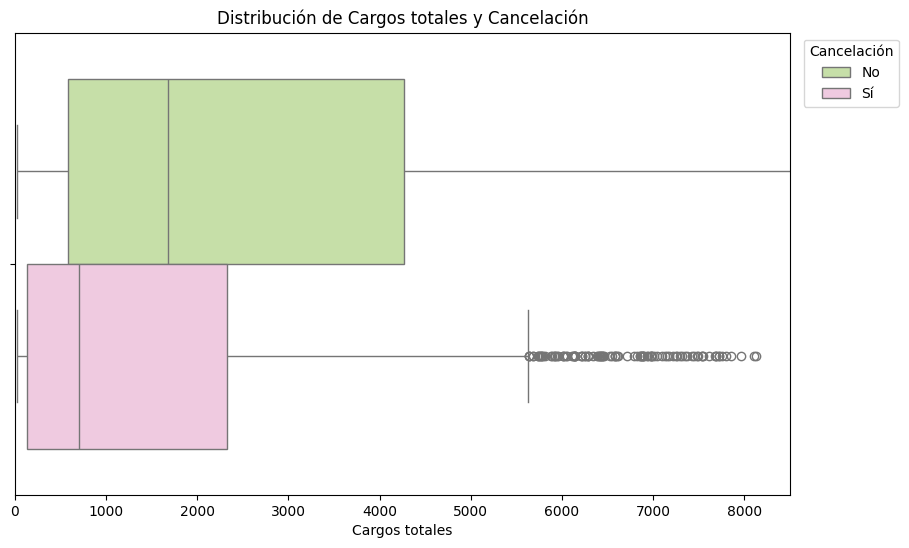

In [312]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(data=variables_numericas, x='ChargesTotal', hue='Churn', palette='PiYG_r')
ax.set_title('Distribución de Cargos totales y Cancelación')
ax.set_xlabel('Cargos totales')
ax.set_xlim(0,8500)
ax.legend(title="Cancelación",labels=['No', 'Sí'], loc='upper right', bbox_to_anchor=(1,0.70,0.15,0.3))

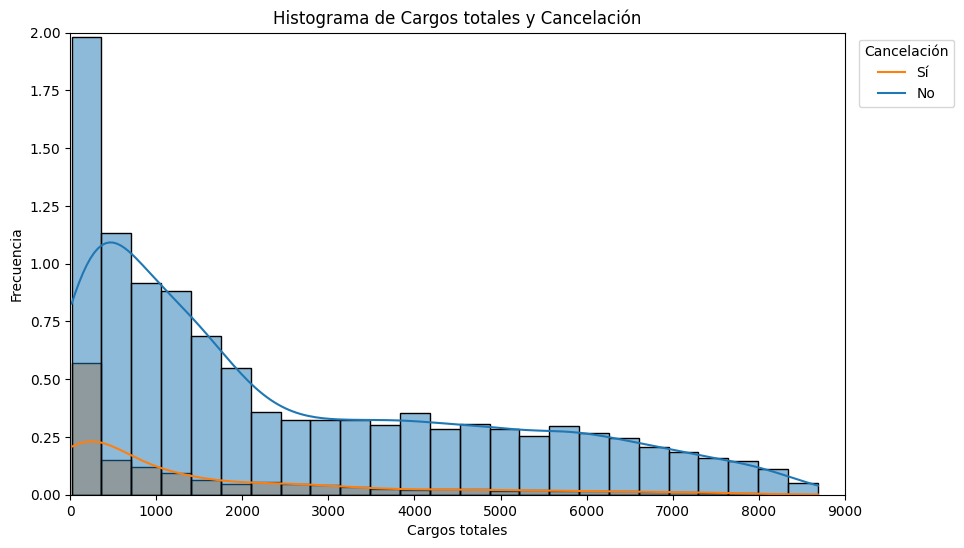

In [313]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(variables_numericas,x='ChargesTotal', hue='Churn',kde=True, stat='frequency')
ax.set_title('Histograma de Cargos totales y Cancelación')
ax.set_xlabel('Cargos totales')
ax.set_ylabel('Frecuencia')
ax.set_xlim(0,9000)
ax.set_ylim(0,2)
ax.legend(title="Cancelación",labels=['Sí', 'No'], loc='upper right', bbox_to_anchor=(1,0.70,0.15,0.3))
plt.show()

### $\color{yellow}{\textbf{Análisis de valores atípícos en Tenure y ChargesTotal}}$

In [314]:
import numpy as np

In [315]:
#Filtro para separar los clientes que han cancelado
churn = variables_numericas['Churn'] == 1
#Creamos un dataframe con las variables que presentan datos atípicos
df_atipicos = variables_numericas[['Tenure', 'ChargesTotal', 'Churn']]
#Acá aplicamos el filtro anterior para quedarnos con los datos de los clientes que han hecho churn
df_atipicos = df_atipicos[churn]


In [316]:
variables_numericas['Churn'].value_counts()

,count
Churn,
0,5163
1,1869


In [317]:
indices_eliminar = []

In [318]:
#Definimos los límites superior e inferior para identificar los valores atípicos en Tenure
q1, q3 = np.percentile(df_atipicos['Tenure'], [25,75])
ric = q3 - q1
ten_inferior = q1 - (1.5 * ric)
ten_superior = q3 + (1.5 * ric)
#Guaramos los indices de los valores atípicos identificados
indice_atipicos_ten = df_atipicos[(df_atipicos['Tenure'] < ten_inferior) | (df_atipicos['Tenure'] > ten_superior)].index
indice_atipicos_ten

Index([ 115,  514,  625,  994, 1066, 1333, 1514, 1738, 1958, 2003, 2282, 2453,
       2730, 3175, 3425, 3752, 4285, 4648, 4828, 5079, 5199, 6055, 6230],
      dtype='int64')

In [319]:
#Los indices los guardAmos en la lista indices_eliminar
indices_eliminar.extend(indice_atipicos_ten)

In [320]:
#Contamos la cantidad de datos a eliminar
len(indices_eliminar)

23

In [321]:
#Definimos los límites superior e inferior para identificar los valores atípicos en Charges total
q1, q3 = np.percentile(df_atipicos['ChargesTotal'], [25,75])
ric = q3 - q1
charges_inferior = q1 - (1.5 * ric)
charges_superior = q3 + (1.5 * ric)
#Guaramos los indices de los valores atípicos identificados
indice_atipicos_char = df_atipicos[(df_atipicos['ChargesTotal'] < charges_inferior) | (df_atipicos['ChargesTotal'] > charges_superior)].index
len(indice_atipicos_char)

109

In [322]:
#Los indices los guardmos en la lista indices_eliminar
indices_eliminar.extend(indice_atipicos_char)

In [323]:
#Contamos la cantidad de datos a eliminar
len(indices_eliminar)

132

In [324]:
#Nos aseguramos que los indices no se repitan
indices_eliminar = list(set(indices_eliminar))
len(indices_eliminar)

113

In [325]:
#Eliminamos los indices de los valores atípicos del df variables_numericas y
#guardamos los resultados en otro df llamado df_limpio
df_limpio = variables_numericas.drop(indices_eliminar)

In [326]:
df_limpio['Churn'].value_counts()

,count
Churn,
0,5163
1,1756


In [327]:
df_limpio.columns

Index(['SeniorCitizen', 'Tenure', 'ChargesMonthly', 'ChargesTotal', 'Churn'], dtype='object')

In [328]:
from scipy import stats

In [329]:
"""
Calculo de coeficiente de correlación biserial entre la variable Churn y las variables numéricas
para determinar la correlación entre las variables numéricas  y la variable categórica churn
después de la eliminación de los valores atípicos
"""
columnas = df_limpio.columns.drop(['SeniorCitizen', 'Churn'])
coeficiente_biserial = []
for columna in columnas:
  coeficiente = stats.pointbiserialr(df_limpio[columna], df_limpio['Churn'])
  coeficiente_biserial.append((columna,coeficiente[0]))
coeficiente_biserial

[('Tenure', np.float64(-0.40390397642415093)),
 ('ChargesMonthly', np.float64(0.1649899614928683)),
 ('ChargesTotal', np.float64(-0.2648650406995252))]

<Axes: xlabel='Tenure'>

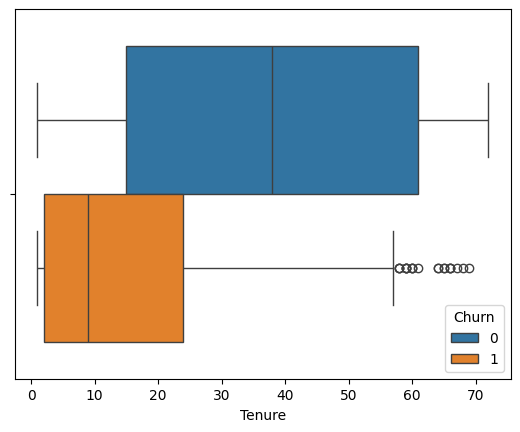

In [330]:
"""
Verificación de la distribución de Tenure y Churn después de elimnar los
valores atípicos
"""
sns.boxplot(data=df_limpio, x='Tenure', hue='Churn')

<Axes: xlabel='Tenure', ylabel='Frequency'>

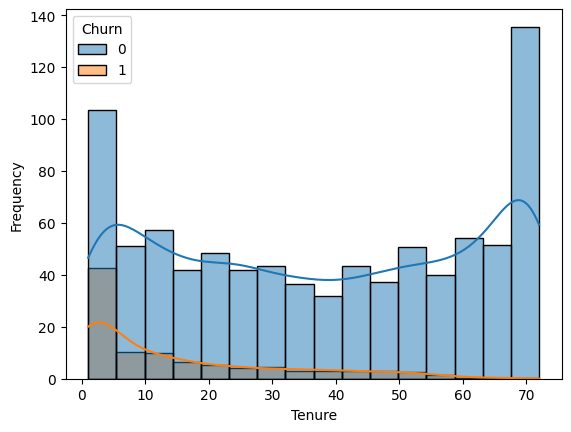

In [331]:
"""
Verificación de la distribución de Tenure y Churn después de elimnar los
valores atípicos
"""
sns.histplot(df_limpio,x='Tenure', hue='Churn',kde=True, stat='frequency')

<Axes: xlabel='ChargesTotal'>

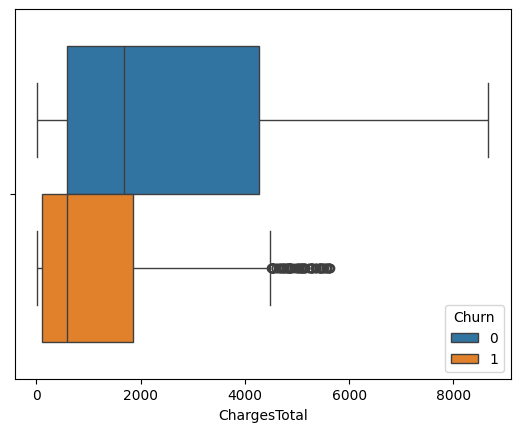

In [332]:
"""
Verificación de la distribución de Charges total y Churn después de elimnar los
valores atípicos
"""
sns.boxplot(data=df_limpio, x='ChargesTotal', hue='Churn')

<Axes: xlabel='ChargesTotal', ylabel='Frequency'>

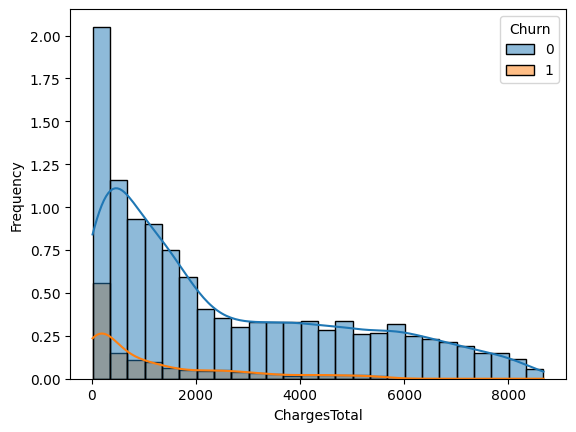

In [333]:
"""
Verificación de la distribución de Charges total y Churn después de elimnar los
valores atípicos
"""
sns.histplot(df_limpio,x='ChargesTotal', hue='Churn',kde=True, stat='frequency')

In [334]:
"""
Correlación entre las variables numéricas despúes de eliminar
los valores atípicos
"""
df_limpio[['Tenure', 'ChargesMonthly','ChargesTotal']].corr()

,Tenure,ChargesMonthly,ChargesTotal
Tenure,1.000000,0.227201,0.821982
ChargesMonthly,0.227201,1.000000,0.639142
ChargesTotal,0.821982,0.639142,1.000000


### $\color{yellow}{\textbf{Dividiendo entre variables explicativas y objetivo}}$

In [335]:
X = clientes.drop(['Churn', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport',
                   'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'ChargesTotal'], axis=1)
y = clientes.Churn

### $\color{yellow}{\textbf{Codificación de las variables categóricas independientes}}$

In [336]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [337]:
columnas = X.columns

In [338]:
one_hot = make_column_transformer((OneHotEncoder(drop='first'),
                                   ['SeniorCitizen', 'InternetService',
                                    'Contract', 'PaymentMethod']),
                                    remainder='passthrough',
                                    sparse_threshold=0,
                                    force_int_remainder_cols=False)

one_hot

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  sparse_threshold=0,
                  transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                 ['SeniorCitizen', 'InternetService',
                                  'Contract', 'PaymentMethod'])])

In [339]:
X = one_hot.fit_transform(X)
X

array([[ 0.  ,  0.  ,  0.  , ...,  1.  ,  9.  , 65.6 ],
       [ 0.  ,  0.  ,  0.  , ...,  1.  ,  9.  , 59.9 ],
       [ 0.  ,  1.  ,  0.  , ...,  0.  ,  4.  , 73.9 ],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  1.  ,  2.  , 50.3 ],
       [ 0.  ,  0.  ,  0.  , ...,  1.  , 67.  , 67.85],
       [ 0.  ,  0.  ,  0.  , ...,  0.  , 63.  , 59.  ]])

In [340]:
one_hot.get_feature_names_out(columnas)

array(['onehotencoder__SeniorCitizen_1',
       'onehotencoder__InternetService_fiber optic',
       'onehotencoder__InternetService_no',
       'onehotencoder__Contract_one-year',
       'onehotencoder__Contract_two-year',
       'onehotencoder__PaymentMethod_credit card',
       'onehotencoder__PaymentMethod_electronic check',
       'onehotencoder__PaymentMethod_mailed check', 'remainder__Tenure',
       'remainder__ChargesMonthly'], dtype=object)

In [341]:
one_hot.get_feature_names_out(columnas)

array(['onehotencoder__SeniorCitizen_1',
       'onehotencoder__InternetService_fiber optic',
       'onehotencoder__InternetService_no',
       'onehotencoder__Contract_one-year',
       'onehotencoder__Contract_two-year',
       'onehotencoder__PaymentMethod_credit card',
       'onehotencoder__PaymentMethod_electronic check',
       'onehotencoder__PaymentMethod_mailed check', 'remainder__Tenure',
       'remainder__ChargesMonthly'], dtype=object)

In [342]:
df_codificado = pd.DataFrame(X, columns= one_hot.get_feature_names_out(columnas))

In [343]:
df_codificado.head()

,onehotencoder__SeniorCitizen_1,onehotencoder__InternetService_fiber optic,onehotencoder__InternetService_no,onehotencoder__Contract_one-year,onehotencoder__Contract_two-year,onehotencoder__PaymentMethod_credit card,onehotencoder__PaymentMethod_electronic check,onehotencoder__PaymentMethod_mailed check,remainder__Tenure,remainder__ChargesMonthly
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,65.6
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,59.9
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,73.9
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0,98.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,83.9


### $\color{yellow}{\textbf{Codificando variable objetivo}}$

In [344]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


In [345]:
y

array([0, 0, 1, ..., 0, 0, 0])

### $\color{yellow}{\textbf{Analizando la proporción de cancelación para encontrar desbalanceo}}$

In [346]:
clientes.Churn.value_counts(normalize=True)

,proportion
Churn,
no,0.734215
yes,0.265785


In [347]:
clientes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Churn             7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   Tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

##$\color{yellow}{\textbf{Modelado predictivo}}$

###$\color{yellow}{\textbf{División de los datos en entrenamiento, validación y prueba}}$

In [348]:
#Importamos el módulo para dividir los datos
from sklearn.model_selection import train_test_split

In [349]:
# Dividimos los datos en entrenamiento y prueba
X, X_test, y, y_test = train_test_split(X,y, test_size=0.30, stratify=y, random_state=42)

In [350]:
#Dividimos los datos de entrenamiento, uno para el aprendizaje y otro para validar las generalizaciones del modelo
X_train, X_val, y_train, y_val = train_test_split(X,y, stratify=y, random_state=42)

###$\color{yellow}{\textbf{Normalización y estandarización  de los datos}}$

In [351]:
#Importamos RobusScaler para el escalamiento de los datos, ya que es robusto a los datoa atípicos
# y no tiene el supuesto de que los datos tienen una distribución normal
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()

X_train = robust_scaler.fit_transform(X_train)
X_val = robust_scaler.transform(X_val)
X_test = robust_scaler.transform(X_test)

In [352]:
X_train

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.0212766 , -0.44586569],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.80851064,  0.37825491],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.59574468,  0.44221106],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.08510638,  0.69255368],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.53191489, -0.10507081],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.85106383, -0.21927821]])

In [353]:
df_normalizado = pd.DataFrame(X_train,columns= one_hot.get_feature_names_out(columnas))
df_normalizado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3691 entries, 0 to 3690
Data columns (total 10 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   onehotencoder__SeniorCitizen_1                 3691 non-null   float64
 1   onehotencoder__InternetService_fiber optic     3691 non-null   float64
 2   onehotencoder__InternetService_no              3691 non-null   float64
 3   onehotencoder__Contract_one-year               3691 non-null   float64
 4   onehotencoder__Contract_two-year               3691 non-null   float64
 5   onehotencoder__PaymentMethod_credit card       3691 non-null   float64
 6   onehotencoder__PaymentMethod_electronic check  3691 non-null   float64
 7   onehotencoder__PaymentMethod_mailed check      3691 non-null   float64
 8   remainder__Tenure                              3691 non-null   float64
 9   remainder__ChargesMonthly                      3691 

###$\color{yellow}{\textbf{Análisis de multicolinealidad entre las variables del modelo}}$

In [354]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Realizamos el análisis de  multicolinealidad en los datos de entrenamiento ya normalizados
df = df_normalizado.copy()
vif_data = pd.DataFrame()
vif_data['Feature'] = df.columns
vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif_data

,Feature,VIF
0,onehotencoder__SeniorCitizen_1,1.301516
1,onehotencoder__InternetService_fiber optic,4.562799
2,onehotencoder__InternetService_no,4.190815
3,onehotencoder__Contract_one-year,1.656216
4,onehotencoder__Contract_two-year,2.710009
5,onehotencoder__PaymentMethod_credit card,1.555995
6,onehotencoder__PaymentMethod_electronic check,2.117935
7,onehotencoder__PaymentMethod_mailed check,1.841750
8,remainder__Tenure,2.565206
9,remainder__ChargesMonthly,6.443351


In [355]:
"""
Descartamos la variable ChargesMonthly ya que tiene un vif >= 5
Descartamos la variable Internet Service no ya que se relaciona con internet Service fiber optic
Nos quedamos con las variables asociadas con el método de pago ya que el valor de vif es bajo
Lo mismo sucede con las variables relacionadas con el tipo de contrato
"""
df = df.drop(columns=['onehotencoder__InternetService_no', 'remainder__ChargesMonthly'])
vif_data = pd.DataFrame()
vif_data['Feature'] = df.columns
vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif_data

,Feature,VIF
0,onehotencoder__SeniorCitizen_1,1.292128
1,onehotencoder__InternetService_fiber optic,1.995024
2,onehotencoder__Contract_one-year,1.561005
3,onehotencoder__Contract_two-year,2.385299
4,onehotencoder__PaymentMethod_credit card,1.436946
5,onehotencoder__PaymentMethod_electronic check,1.908582
6,onehotencoder__PaymentMethod_mailed check,1.515066
7,remainder__Tenure,2.247604


In [356]:
#Borramos las columnas mencionadas anteriormente
_X_train = np.delete(X_train, [2,9], axis=1)
_X_val = np.delete(X_val, [2,9], axis=1)
_X_test = np.delete(X_test, [2,9], axis=1)

###$\color{yellow}{\textbf{Balanceo de los datos}}$

In [357]:
"""
Se balancea los datos de entrenamiento,
dado que detectamos un desbalanceo en las clases de churn
"""
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(_X_train, y_train)

##$\color{yellow}{\textbf{Entrenamiento de los modelos}}$

###$\color{yellow}{\textbf{Modelo dummy}}$

In [358]:
from sklearn.dummy import DummyClassifier

In [359]:
modelo_base = DummyClassifier()

In [360]:
#Entrenamiento del modelo base
modelo_base.fit(X_train_bal, y_train_bal)

DummyClassifier()

In [361]:
print(f'La exactidud del modelo de entrenamiento es {modelo_base.score(X_train_bal,y_train_bal)}')

La exactidud del modelo de entrenamiento es 0.5


###$\color{yellow}{\textbf{Árbol de Decisión}}$

In [362]:
from sklearn.tree import DecisionTreeClassifier

In [363]:
modelo_arbol = DecisionTreeClassifier(max_depth=5)
#Entrenamiento del modelo árbol
modelo_arbol.fit(X_train_bal, y_train_bal)

DecisionTreeClassifier(max_depth=5)

In [364]:
#Métrica del modelo de entrenamiento
print(f'La exactidud del modelo de entrenamiento es {modelo_arbol.score(X_train_bal,y_train_bal)}')

La exactidud del modelo de entrenamiento es 0.772140221402214


In [365]:
##Métrica del modelo con los datos de validación
print(f'La exactidud del modelo de validación es {modelo_arbol.score(_X_val,y_val)}')

La exactidud del modelo de validación es 0.7441104792851341


### **Modelo Regresión Logística**

In [366]:
from sklearn.linear_model import LogisticRegression

In [367]:
modelo_regresion = LogisticRegression(random_state=42)
#Entrenamiento del modelo de regresión logística
modelo_regresion.fit(X_train_bal, y_train_bal)

LogisticRegression(random_state=42)

In [368]:
#Métrica del modelo de entrenamiento
print(f'La exactidud del modelo de entrenamiento es {modelo_regresion.score(X_train_bal,y_train_bal)}')

La exactidud del modelo de entrenamiento es 0.7745387453874538


###$\color{yellow}{\textbf{Evaluación de los modelos}}$

In [369]:
#Importamos las métricas para evaluar los modelos
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

####$\color{yellow}{\textbf{Evaluación del modelo Árbol de Decisión}}$

In [370]:
y_predicho = modelo_arbol.predict(_X_val)

matriz_confusion = confusion_matrix(y_val, y_predicho)

print(matriz_confusion)

[[661 243]
 [ 72 255]]


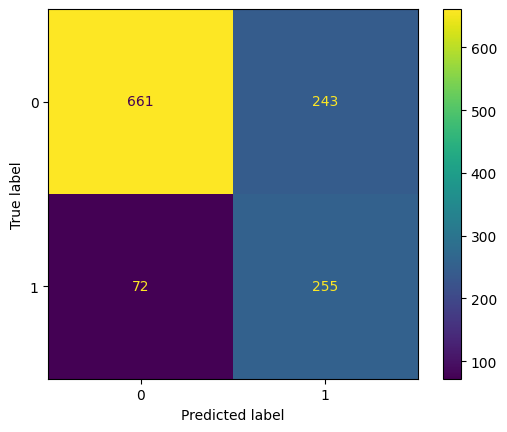

In [371]:
vis_matriz_confusion = ConfusionMatrixDisplay(matriz_confusion)

vis_matriz_confusion.plot();

#####$\color{yellow}{\textbf{Informe de métricas}}$

In [372]:
from sklearn.metrics import classification_report

In [373]:
print(classification_report(y_val, y_predicho))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81       904
           1       0.51      0.78      0.62       327

    accuracy                           0.74      1231
   macro avg       0.71      0.76      0.71      1231
weighted avg       0.80      0.74      0.76      1231



#####$\color{yellow}{\textbf{Análisis de curvas ROC y Precision x Recall}}$

In [374]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

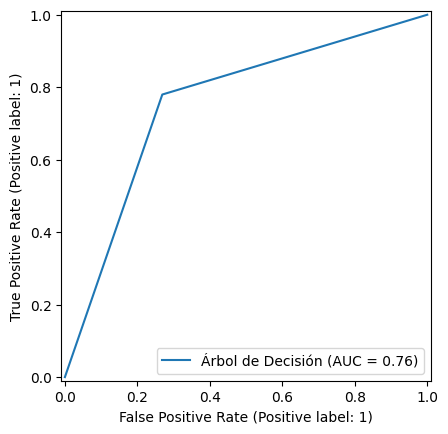

In [375]:
RocCurveDisplay.from_predictions(y_val, y_predicho, name='Árbol de Decisión');

In [376]:
print(f'El área debajo de la curva ROC es {roc_auc_score(y_val, y_predicho)}')

El área debajo de la curva ROC es 0.7555056020134773


In [377]:
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score

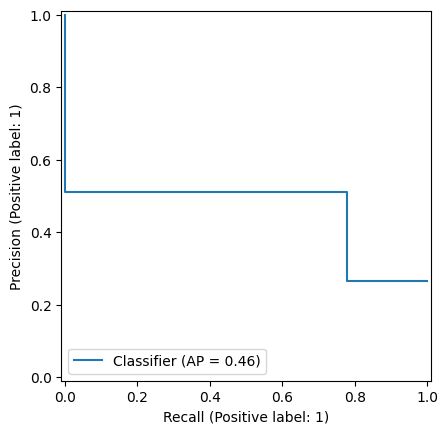

In [378]:
PrecisionRecallDisplay.from_predictions(y_val, y_predicho);

In [379]:
print(f'El área debajo de la curva Precision vs Recall es {average_precision_score(y_val, y_predicho)}')

El área debajo de la curva Precision vs Recall es 0.4577926698708622


####$\color{yellow}{\textbf{Evaluación del modelo Regresión logística}}$

In [380]:
y_regresion_predicho = modelo_regresion.predict(_X_val)

####$\color{yellow}{\textbf{Reporte de métricas}}$

In [381]:
print(classification_report(y_val, y_regresion_predicho))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       904
           1       0.52      0.77      0.62       327

    accuracy                           0.75      1231
   macro avg       0.71      0.76      0.72      1231
weighted avg       0.80      0.75      0.76      1231



In [382]:
matriz_confusion_regresion = confusion_matrix(y_val, y_regresion_predicho)

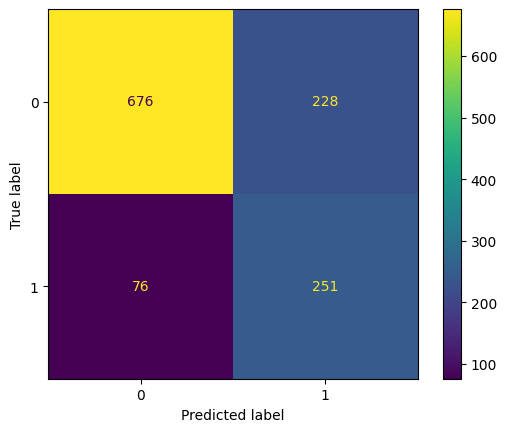

In [383]:
vis_matriz_confusion_regresion = ConfusionMatrixDisplay(matriz_confusion_regresion)

vis_matriz_confusion_regresion.plot();


#####$\color{yellow}{\textbf{Análisis de curvas ROC y Precision x Recall}}$

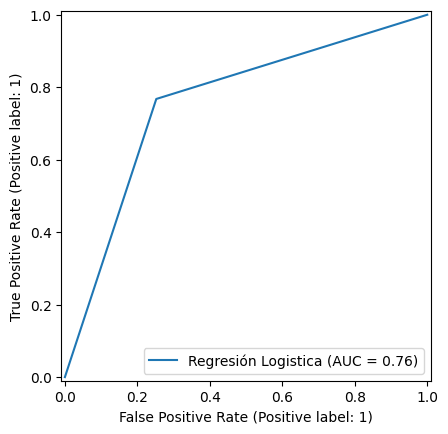

In [384]:
RocCurveDisplay.from_predictions(y_val, y_regresion_predicho, name='Regresión Logistica');

In [385]:
print(f'El área debajo de la curva ROC es {roc_auc_score(y_val, y_regresion_predicho)}')

El área debajo de la curva ROC es 0.757685854239398


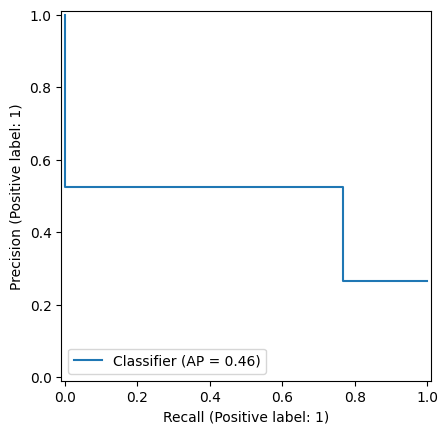

In [386]:
PrecisionRecallDisplay.from_predictions(y_val, y_regresion_predicho);

In [387]:
print(f'El área debajo de la curva Precision vs Recall es {average_precision_score(y_val, y_regresion_predicho)}')

El área debajo de la curva Precision vs Recall es 0.4639589012118613


#####$\color{yellow}{\textbf{Evaluación de los modelos con validación cruzada a través de un pipeline}}$

In [388]:
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate

In [389]:
clientes.columns

Index(['Churn', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'ChargesMonthly', 'ChargesTotal'],
      dtype='object')

In [390]:
_X = clientes.drop(columns=['Churn','Partner', 'Dependents',
                            'PhoneService', 'MultipleLines', 'OnlineSecurity',
                            'OnlineBackup', 'DeviceProtection',
                            'TechSupport', 'StreamingTV',
                            'StreamingMovies', 'PaperlessBilling',
                            'ChargesMonthly', 'ChargesTotal'], axis=1)
_y = clientes.Churn

In [391]:
Y = label_encoder.fit_transform(_y)


In [392]:
_X.columns

Index(['SeniorCitizen', 'Tenure', 'InternetService', 'Contract',
       'PaymentMethod'],
      dtype='object')

In [393]:
var_categoricas = ['SeniorCitizen', 'InternetService', 'Contract', 'PaymentMethod']
var_numericas = ['Tenure']

In [394]:
#Instanciamos los modelos
arbol = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')

regresion = LogisticRegression(random_state=42, class_weight='balanced')

In [395]:
#Preprocesador es la variable que contiene los pasos de preprocesamiento a seguir
preprocesador = ColumnTransformer(
                    transformers=[
                        ('num', RobustScaler(), var_numericas),
                        ('cat', OneHotEncoder(drop='first'), var_categoricas)],
                    remainder='passthrough'
                    )

In [396]:
#Creamos el pipeline para el árbol de decisión
pipeline = imbpipeline(steps=[('preprocesador', preprocesador),
                                ('muestreo',SMOTE(random_state=42)),
                                ('árbol', arbol)])


In [397]:
#Creamos el pipeline para la regresión logística
pipeline_regresion = imbpipeline(steps=[('preprocesador', preprocesador),
                                ('muestreo',SMOTE(random_state=42)),
                                ('regresión logistica', regresion)])

In [398]:
#Creamos el objeto que se encarga de la validación cruzada
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [399]:
#Aplicamos la validación cruzada para el modelo árbol
cross_validation_arbol = cross_val_score(pipeline, _X, Y, cv=skfold, scoring='recall')

In [400]:
cross_val_arbol = cross_validate(pipeline, _X, Y, cv=skfold, scoring=['precision','recall'])

In [401]:
print(f'{cross_val_arbol["test_precision"].mean()} ± {cross_val_arbol["test_precision"].std()}')

0.5244039547412995 ± 0.02111522698715663


In [402]:
print(f'{cross_val_arbol["test_recall"].mean()} ± {cross_val_arbol["test_recall"].std()}')

0.7629840432395234 ± 0.02368497393095406


In [403]:
#Obtenemos el promedio de la métrica precisión de las 5 iteraciones
print(f'{cross_validation_arbol.mean()} +- {cross_validation_arbol.std()}')

0.7629840432395234 +- 0.02368497393095406


In [404]:
#Aplicamos la validación cruzada para el regresión logística
cross_validation_regresion = cross_val_score(pipeline_regresion, _X, Y, cv=skfold, scoring='precision')

In [405]:
#Obtenemos el promedio de la métrica precisión de las 5 iteraciones
print(f'{cross_validation_regresion.mean()} +- {cross_validation_regresion.std()}')

0.5065766670606611 +- 0.013801336584742255


In [406]:
cross_val_regresion = cross_validate(pipeline_regresion, _X, Y, cv=skfold, scoring=['precision','recall'])

In [407]:
print(f'{cross_val_regresion["test_precision"].mean()} ± {cross_val_regresion["test_precision"].std()}')

0.5065766670606611 ± 0.013801336584742255


In [408]:
print(f'{cross_val_regresion["test_recall"].mean()} ± {cross_val_regresion["test_recall"].std()}')

0.8041734168685754 ± 0.012121023518463059


#####$\color{yellow}{\textbf{Prueba del modelo Árbol de Decisión con datos de prueba}}$

In [409]:
y_prueba_predicho = modelo_arbol.predict(_X_test)

In [410]:
print(classification_report(y_test, y_prueba_predicho))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1549
           1       0.50      0.78      0.61       561

    accuracy                           0.74      2110
   macro avg       0.70      0.75      0.71      2110
weighted avg       0.79      0.74      0.75      2110



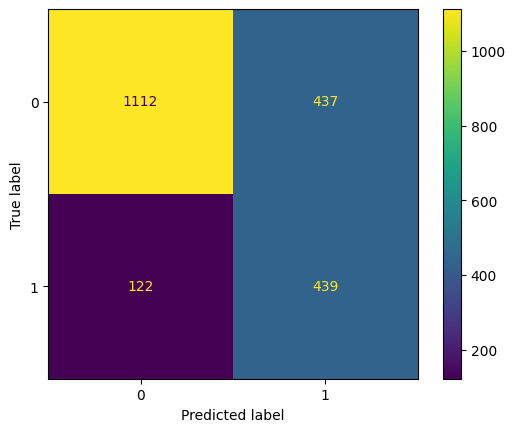

In [411]:
ConfusionMatrixDisplay.from_predictions(y_test, y_prueba_predicho);

#####$\color{yellow}{\textbf{Prueba del modelo Regresión Logística con datos de prueba}}$

In [412]:
y_prueba_predicho = modelo_regresion.predict(_X_test)

In [413]:
print(classification_report(y_test, y_prueba_predicho))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1549
           1       0.51      0.80      0.62       561

    accuracy                           0.74      2110
   macro avg       0.71      0.76      0.71      2110
weighted avg       0.80      0.74      0.76      2110



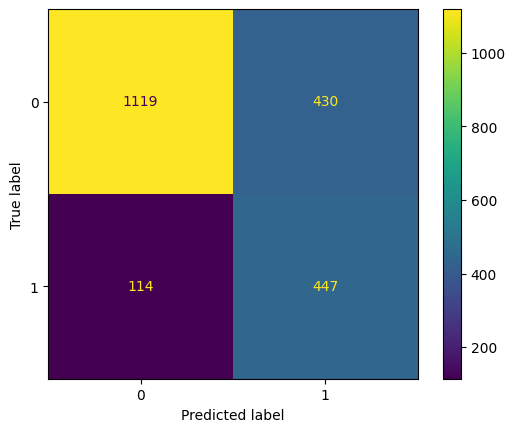

In [414]:
ConfusionMatrixDisplay.from_predictions(y_test, y_prueba_predicho);

#####$\color{yellow}{\textbf{Análisis de importancia de las variables de la regresión}}$

In [415]:
#Coeficientes del modelo de regresión logistica
modelo_regresion.coef_

array([[ 0.33387769,  1.28046191, -0.80446531, -1.74079071, -0.04950013,
         0.63923315, -0.13502328, -1.43053107]])

In [416]:
df.columns

Index(['onehotencoder__SeniorCitizen_1',
       'onehotencoder__InternetService_fiber optic',
       'onehotencoder__Contract_one-year', 'onehotencoder__Contract_two-year',
       'onehotencoder__PaymentMethod_credit card',
       'onehotencoder__PaymentMethod_electronic check',
       'onehotencoder__PaymentMethod_mailed check', 'remainder__Tenure'],
      dtype='object')

In [417]:
#Intercepto del modelo de regresión logistica
modelo_regresion.intercept_

array([-0.67964791])

In [418]:
from sklearn.inspection import permutation_importance
results = permutation_importance(modelo_regresion, _X_test, y_test, scoring='recall')
for i, v in enumerate(results.importances_mean):
    print(f'Feature: {i}, Score: {v *100:.5f}')

Feature: 0, Score: 0.49911
Feature: 1, Score: 7.95009
Feature: 2, Score: 2.49554
Feature: 3, Score: 11.97861
Feature: 4, Score: 0.99822
Feature: 5, Score: 1.21212
Feature: 6, Score: -0.67736
Feature: 7, Score: 15.61497


#####$\color{yellow}{\textbf{Análisis de importancia de las variables del Árbol de Decisión}}$

In [423]:
importances = modelo_arbol.feature_importances_ * 100
features = ['SeniorCitizen', 'Fiber optic', 'Contract_one-year','Contract_two-year',
            'PM credit card','PMelectronic check','PM mailed check','Tenure']

for i in range(len(importances)):
  print(f'Feature: {i}, Score: {importances[i]}')


Feature: 0, Score: 0.18597199948158935
Feature: 1, Score: 14.520127435534105
Feature: 2, Score: 25.741275153910287
Feature: 3, Score: 41.847612395772636
Feature: 4, Score: 0.0
Feature: 5, Score: 3.1522922359293712
Feature: 6, Score: 0.0
Feature: 7, Score: 14.552720779372006


In [429]:
importances = np.sort(importances)[::-1]
importances

array([41.8476124 , 25.74127515, 14.55272078, 14.52012744,  3.15229224,
        0.185972  ,  0.        ,  0.        ])

In [437]:
dic_importances = {
                    'feature': ['Contract_two-year','Contract_one-year',
                                'Fiber optic','Tenure', 'PMelectronic check',
                                'SeniorCitizen', 'PM credit card','PM mailed check'],
                    'importance': importances
                  }

In [438]:
df_importances = pd.DataFrame(dic_importances)
df_importances

,feature,importance
0,Contract_two-year,41.847612
1,Contract_one-year,25.741275
2,Fiber optic,14.552721
3,Tenure,14.520127
4,PMelectronic check,3.152292
5,SeniorCitizen,0.185972
6,PM credit card,0.000000
7,PM mailed check,0.000000


In [439]:
df_importances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature     8 non-null      object 
 1   importance  8 non-null      float64
dtypes: float64(1), object(1)
memory usage: 260.0+ bytes


Text(0, 0.5, 'Característica')

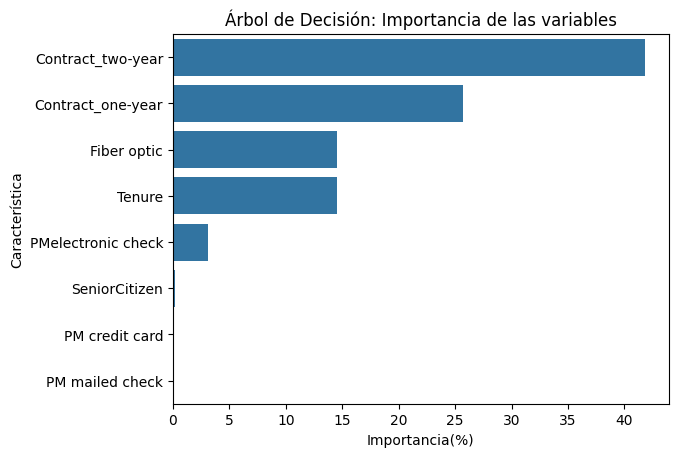

In [443]:
fig, ax = plt.subplots()
ax = sns.barplot(data=df_importances, x='importance', y = 'feature', orient='h')
ax.set_title('Árbol de Decisión: Importancia de las variables')
ax.set_xlabel('Importancia(%)')
ax.set_ylabel('Característica')


## \begin{align}
    \color{yellow}{\textbf{📄Informe de predicción de cancelación}}
    \end{align}

### \begin{align}
    \color{yellow}{\textbf{Introducción}}
    \end{align}

La empresa <strong>Telecom X Latinoamérica</strong> está presentando una alta tasa de cancelación, es por eso que ha encargado a su equipo de análisis de datos y de Machine Learning dos tareas distintas pero complementarias: a partir del análisis exploratorio de los datos de los clientes identificar los factores que están influyendo en la baja de los servicios y la contrucción de modelos de clasificación que sean capaces de predecir la probabilidad de que un cliente renuncie.

En el reporte exploratorio de los datos, <a href="https://github.com/JGarcia575/challenge_telecomX.git" >ver informe</a>, se destacan:
<ul>
  <li>Edad.</li>
  <li>Tipo de contrato.</li>
  <li>Antiguedad.</li>
  <li>El servicio de internet.</li>
  <li>El cargo mensual.</li>
  <li>El cargo total.</li>
</ul>

entre los clientes que han disertado.

A partir de los datos ya tratados por el equipo de análisis de datos y apoyándonos en los hallazgos encontrados en el informe anterior, se construiran modelos predictivos de clasificación que tengan la capacidad de predecir si un cliente abandonará los servicios de la empresa. El rendimiento de los modelos serán evaluados y se eligirá el que tiene mejor rendimiento a partir de los resultados de las métricas. Por último, se proponen estrategias de retención basadas en los resultados obtenidos.



### \begin{align}
    \color{yellow}{\textbf{Métodología}}
    \end{align}

Los datos fueron preprocesados para que los algoritmos de clasificación de Machine Learning fueran capaces de interpretarlos correctamente.
El preprocesamiento incluyó:
<ul>
  <li>Eliminación de valores nulos.</li>
  <li>Codificación de las variables categóricas.</li>
  <li>Normalización de las variables numéricas.</li>
  <li>Análisis de correlación de las variables.</li>
  <li>Balanceo de datos.</li>
</ul>

Luego del procesamiento, se entrenaron dos tipos de modelos: Árbol de Decisión y Regresión Logística. Para evaluar que tan bien generalizó el modelo y para ajustar los hiperparámetros se realizó la validación del modelo utilizando una parte de los datos y, también, a través de la validación cruzada.

Por último, se realizó la evaluación final de los modelos utilizando los datos de prueba y se analizó la importancia de las variables para cada modelo.


### \begin{align}
    \color{yellow}{\textbf{Resultados}}
    \end{align}

### _<strong>Evaluación con datos de entrenamiento</strong>_
En el entrenamiento los modelos obtuvieron los siguientos puntajes de exactitud(accuracy): 0.75 para el árbol de decisión y 0.77 para el modelo de regresión, lo cual nos indica que ambos no están sobreajustando los datos.
### _<strong>Evaluación con datos de validación</strong>_
En la tabla 1, se muestra los resultados de la validación para las métricas precision, recall y f1 para el árbol de decisión.


<table>
    <thead>
        <tr>
            <th align='center'>Modelo: Árbol</th>
            <th colspan=4 align='center'>Métricas</tr>            
        </tr>
    </thead>
    <thead>
        <tr>
            <th>Clase</th>
            <th>Precision</th>
            <th>Recall</th>
            <th>F1</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td align="center">No</td>
            <td  align="center">0.90</td>
            <td  align="center">0.73</td>
            <td  align="center">0.81</td>                        
        </tr>
        <tr>
            <td align="center">Si</td>
            <td  align="center">0.51</td>
            <td  align="center">0.71</td>
            <td  align="center"> 0.62 </td>            
        </tr>        
    </tbody>
</table>

La métricas muestran que el árbol de decisión puede identificar correctamente los que hicieron churn(70% de sensibilidad). Sin embargo, solo el 51% de las predicciones de churn hechas por el modelo fueron correctas, lo que se refleja en la métrica de precisión.

La matriz de confusión ayuda a avisualizar lo que las métricas están indicando:

<img src='https://raw.githubusercontent.com/JGarcia575/challenge_telecomX_parte_2/refs/heads/main/img/matriz_confusion_arbol.png'>

En la matriz se observa bien que tiene una alta tasa de verdaderos positivos(255) y una baja tasa de falsos negativos(72), lo que se refleja en la métrica sesibilidad( o recall). Sin embargo, tiene una alta tasa de falsos positivos(243), similar a la tasa de verdederos positivos(255), lo cual hace que la precisión sea de aproximadamente 50%.

La curva ROC indaga sobre la capacidad del modelo para distinguir las clases, mostrando el balance entre la tasa de verdaderos positivos y la tasa falsos positivos. El modelo tiene un de área debajo de la curva del 0.76,puntuación AUC,esto significa que el árbol de decisión es capaz de distinguir entre ambas clases de clientes. No obstante, en el gráfico se observa que a medida que aumenta los verdaderos positivos, también aumenta los falsos positivos y esto implica que el modelo predice más clientes que cancelaron a costa de identificar erróneamente usuarios que no se fueron.

<img src='https://raw.githubusercontent.com/JGarcia575/challenge_telecomX_parte_2/refs/heads/main/img/auc_arbol.png' >

El árbol tiene una limitación y esta se observa en el gráfico de precisión vs sensibilidad. Si observamos este gráfico vemos que el mejor recall que podemos obtener es de aproximadamente 0.78 y la mejor precisión es del 0.52. Si quisieramos aumentar la métrica a 1, la precisión baja drásticamente, y si quisieramos aumentar la precisión, la sensibilidad disminuye también drásticamente. El mejor equibibrio entre sensibilidad y precisión es la combinación que se mencionó anteriormente. Por lo tanto, esto refleja una limitación del modelo.

<img src='https://raw.githubusercontent.com/JGarcia575/challenge_telecomX_parte_2/refs/heads/main/img/pr_arbol.png'>

La tabla 2 muestra las métricas obtenidas para el modelo de regresión con los datos de validación.

<table>
    <thead>
        <tr>
            <th align='center'>Modelo: Regresión logística</th>
            <th colspan=4 align='center'>Métricas</tr>            
        </tr>
    </thead>
    <thead>
        <tr>
            <th>Clase</th>
            <th>Precision</th>
            <th>Recall</th>
            <th>F1</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td align="center">No</td>
            <td  align="center">0.90</td>
            <td  align="center">0.75</td>
            <td  align="center">0.82</td>                        
        </tr>
        <tr>
            <td align="center">Si</td>
            <td  align="center">0.52</td>
            <td  align="center">0.77</td>
            <td  align="center">0.62</td>            
        </tr>        
    </tbody>
</table>

Los resultados son similares a los obtenidos para el árbol de decisión. La métrica precisión es ligeramente superior con respecto a la misma métrica para el árbol. Lo mismo sucede con la métrica de sensibilidad.

La matriz de confusión del algoritmo de clasificación regresión repite lo mismo que lo mencionado para el modelo árbol. Esto significa que encontramos una alta tasa de verdadero positivos(251) y una baja tasa de falso negativos(76), lo cual se refleja en una  métrica alta de recall(0.77). Además, tenemos una alta tasa de falsos positivos, lo cual justifica que la precisión sea del 52%.

<img src='https://raw.githubusercontent.com/JGarcia575/challenge_telecomX_parte_2/refs/heads/main/img/matriz_regresion.png'>

Las curvas ROC y precisión x sesibilidad, repiten lo mismo que para las curvas del modelo árbol.

<div style="display:flex">
<img src='https://raw.githubusercontent.com/JGarcia575/challenge_telecomX_parte_2/refs/heads/main/img/auc_regresion.png'>
<img src='https://raw.githubusercontent.com/JGarcia575/challenge_telecomX_parte_2/refs/heads/main/img/pr_arbol.png'>

</div>

La validación cruzada arroja resultados similares en cuanto a la métrica precisión con respecto a la validación realizada sobre un solo conjunto de datos. Por ejemplo, el modelo árbol de decisión tuvo un una media de precisión de 0.52 ± 0.021, mientras que la regresión logística tuvo un promedio de precisión de  0.51 ± 0.013. No obstante, la puntuación de sensibilidad mejoró para ambos modelos. Dado que el algoritmo de clasificación árbol obtuvo un promedio de 0.76 ± 0.023 de sensibilidad y la regresión  obtuvo una media de sensibilidad de 0.80 ± 0.012.

### <strong>_Evaluación con datos de prueba_</strong>

El rendimiento de los modelos con los datos de prueba es similar al rendimiento obtenido en la validación cruzada. La precisión para los dos modelos se encuentra alrededor del 50% y la sensibilidad para el árbol de decisión es 0.77 y 0.80 para el modelo de regresión logística.

### <strong>_Análisis de importancia de las variables_</strong>

El modelo de regresión que calcula la probabilidad de  evasión de clientes queda descripto por la siguiente ecuación:

$P(Y=1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_1X_3+ \beta_1X_4 + \beta_1X_5 + \beta_1X_6 + \beta_7X_7 + \beta_8X_8)}}$

donde $\beta_0$ es el intercepto de la regresión y $\beta_1$, $\beta_2$, $\beta_3$, $\beta_4$ ... $\beta_8$  son los coeficientes de las variables predictoras.

En este caso, el modelo queda definido por las siguientes variables predictoras:

$X_1$: SeniorCitizen,<br>
$X_2$: Fiber optic,<br>
$X_3$: Contract_one-year, <br>
$X_4$: Contract_two-year, <br>
$X_5$: PaymentMethod credit card', <br>
$X_6$: PaymentMethod electronic check', <br>
$X_7$: PaymentMethod mailed check', <br>
$X_8$: Tenure

y los coeficientes para cada variable independiente son:

$\beta_1$ = 0.33, <br>
$\beta_2$ = 1.28, <br>
$\beta_3$ = -0.80, <br>
$\beta_4$ = -1.74, <br>
$\beta_5$ = -0.05, <br>
$\beta_6$ = 0.63, <br>
$\beta_7$ = -0.13, <br>
$\beta_8$ = -1.42, <br>

Si observamos los coeficientes de la regresión, vemos que las variables Tenure y Contrato de dos años son las que tienen más importancia. El árbol de decisión también le asigna importancia al contrato a dos años. No obstante, este modelo también le asigna más importancia a la variable  Contrato a un año a diferencia de la regresión.

<img src='https://raw.githubusercontent.com/JGarcia575/challenge_telecomX_parte_2/refs/heads/main/img/importancia_arbol.png'>

### \begin{align}
    \color{yellow}{\textbf{Conclusión}}
    \end{align}

Dado que las métricas generales de rendimiento, como el AUC y la precisión promedio, son similares para ambos modelos, y reconociendo que la precisión máxima alcanzable para este problema es del 52%, se priorizó la capacidad de detectar a los clientes en riesgo. Por lo tanto, se eligió el modelo de regresión logística por su mayor sensibilidad (recall) en la validación cruzada y en la evaluación con los datos de prueba.

La regresión logística es un modelo básico pero sencillo de entender ya que de sus coeficientes podemos extraer como influye cada variable independienta en la probabilidad de churn. La cancelación se relaciona de manera positiva: con la edad, con el servicio de fibra óptica y con el método de pago cheque electrónico. Mientras que se relaciona de manera negativa con: los tipos de contratos, con los métodos de pagos tarjeta de crédito y cheque por correo y , por último, con antiguedad.

Las variables más importantes y, por lo tanto más influyentes para el modelo, son: antiguedad y contrato a dos años, las cuales pueden convertirse en el foco de diseños de estrategias para retener los clientes en riesgo de cancelación.

Dado que el modelo es agresivo identificando clientes en riesgo pero con la contra de que de todos los usuarios clasificados como churn, solo la mitad realmente se fue, recomendamos que las estrategias de retención de clientes sean económicas para compensar la debilidad del modelo.